In [1]:
import tensorflow as tf
import jax
import flax
from flax import linen as nn
from jax import numpy as jnp
from jax import random
from einops import einsum, rearrange, reduce
import optax
import matplotlib.pyplot as plt
import pickle
import time
import numpy as np
from flax.training import orbax_utils

import orbax.checkpoint

import functools


import os
import uuid
import datetime

from maze_dataset.plotting import MazePlot
from maze_dataset.tokenization.token_utils import strings_to_coords

from dataset import CustomMazeDataset
from dataset import NumpyLoader

from model import TransformerLM, TransformerConfig


/Users/johannes/miniforge3/envs/maze-goal/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [2]:

# config details
checkpoint_path = "data/2023-10-31_16-24-46"
base_path = "data"
save = True

np_seed = 0
jnp_seed = 0

batch_size = 128
lr = 1e-4
n_train_steps = 10000000

save_every_n_steps = 1000
keep_n_checkpoints = 100

n_worker = 8

# n_eval = 1024
emb_dim: int = 256
num_heads: int = 16
num_layers: int = 12
qkv_dim: int = 256  # 512
mlp_dim: int = 1024  # 2048
max_len = 256

grid_n = 5

In [3]:



@jax.jit
def train_step(state, batch):
    params = state['params']
    opt_state = state['opt_state']
    loss, grads = jax.value_and_grad(loss_fn)(params, batch)
    updates, opt_state = tx.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    step = state['step'] + 1

    return {'params': params, 'opt_state': opt_state, 'loss': loss, 'step': step}

@jax.jit
def eval_step(state, batch):
    params = state['params']
    loss = loss_fn(params, batch)
    return loss

dataset = CustomMazeDataset(include_maze=False)
train_loader = NumpyLoader(dataset, batch_size=batch_size, num_workers=n_worker)

losses = []
eval_losses = []

key = random.PRNGKey(jnp_seed)
rng, key = random.split(key)

config = TransformerConfig(
    vocab_size=dataset.vocab_size,
    output_vocab_size=dataset.vocab_size,
    max_len=max_len,
    emb_dim=emb_dim,
    num_heads=num_heads,
    num_layers=num_layers,
    qkv_dim=qkv_dim,
    mlp_dim=mlp_dim
)

model = TransformerLM(config=config)


def loss_fn(params, batch):
    preds, act = model.apply(params, batch['data'])
    preds = preds[:, 0:-1]
    targets = batch['data'][:, 1:]
    idx = jnp.arange(targets.shape[1])[None, :]
    mask = jnp.where((idx < batch['end_index'][:, None]) & (idx >= batch['start_index'][:, None]), 1., 0.)

    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=preds,
        labels=targets
    ) * mask

    loss = loss.sum() / mask.sum()

    return loss

tx = optax.adamw(lr)

batch = next(iter(train_loader))
params = model.init(rng, batch['data'])

apply_fn = jax.jit(model.apply)

opt_state = tx.init(params)

state = {'params': params, 'opt_state': opt_state, 'loss': 0., 'step': 0}

# checkpoint management / loading model

if save and not checkpoint_path:
    # make new run dir ect

    # Get the current date and time
    current_datetime = datetime.datetime.now()

    # Create a directory name with the date and unique ID
    checkpoint_dir_name = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")

    # Create the full path for the checkpoint directory
    checkpoint_path = os.path.join(base_path, checkpoint_dir_name)

    # Check if the directory already exists
    if not os.path.exists(checkpoint_path):
        # Create the directory
        os.makedirs(checkpoint_path)
        print(f"Checkpoint directory created: {checkpoint_path}")
    else:
        print(f"Checkpoint directory already exists: {checkpoint_path}")

if checkpoint_path:
    orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
    options = orbax.checkpoint.CheckpointManagerOptions(max_to_keep=keep_n_checkpoints)
    checkpoint_manager = orbax.checkpoint.CheckpointManager(checkpoint_path, orbax_checkpointer, options)

    dummy_dict = {
        'state': state,
        'loss': np.array([0.])}


    step = checkpoint_manager.latest_step()

    if step:
        print(f'loading step {step}')
        load_dict = checkpoint_manager.restore(step, items=dummy_dict)
        state = load_dict['state']
        losses = list(load_dict['loss'])



loading step 953000


In [4]:
reverse_map = {v: k for k, v in dataset.tokenizer.tokenizer_map.items()}
vocab_map = dataset.tokenizer.tokenizer_map.get

from dataset import find_from_right

def ints_to_coords(arr):
    # Map the integers in the list back to their corresponding tokens
    tok_list = [reverse_map.get(i) for i in list(np.array(arr))]
    coords = strings_to_coords(tok_list[:find_from_right(tok_list,'<PATH_END>')])
    return coords

In [5]:
model.apply(state["params"], batch["data"][:2], intervention=lambda x, layer: x)

(Array([[[-2.2925186 , -9.66244   , -9.907211  , ..., -0.9442662 ,
          -1.1290259 , -2.6165648 ],
         [ 3.3481827 , -9.749592  , -9.7007675 , ..., -0.5582606 ,
           1.7104595 , -1.4670912 ],
         [-0.9140706 , -8.227923  , -8.327029  , ..., -1.2923465 ,
           0.9014423 , -1.0806873 ],
         ...,
         [-8.051864  , -7.8536158 , -7.8760014 , ...,  1.8560418 ,
           2.8588028 , -0.48173887],
         [-8.009118  , -7.828022  , -7.8512406 , ...,  1.8994629 ,
           3.0053287 , -0.59309745],
         [-7.932233  , -7.7624016 , -7.785763  , ...,  1.929503  ,
           3.1037676 , -0.81382155]],
 
        [[-2.2925186 , -9.66244   , -9.907211  , ..., -0.9442662 ,
          -1.1290259 , -2.6165648 ],
         [ 3.876052  , -7.4630747 , -7.8600135 , ..., -1.0477525 ,
           1.7660744 , -1.800968  ],
         [-0.05687809, -8.116321  , -8.211412  , ..., -1.2615001 ,
           0.5373314 , -1.1881708 ],
         ...,
         [-6.707423  , -7.0495586

# Model analysis

951000
0.17161499


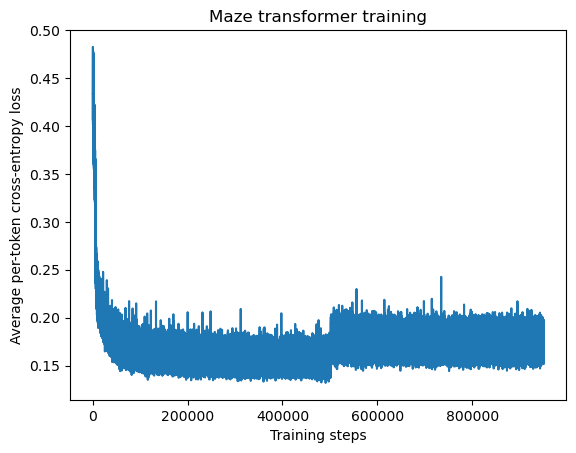

In [6]:
print(len(losses))

plt.plot(losses)
#plt.yscale('log')
#plt.xscale('log')
plt.title('Maze transformer training')
plt.xlabel('Training steps')
plt.ylabel('Average per-token cross-entropy loss')
plt.savefig('maze_transformer_training.pdf')

print(np.mean(losses[-100:]))

In [39]:
#@jax.jit
def optimal_pred_loss_fn(batch):

    path_len = batch['true_preds'].shape[1]
    true_preds = batch['true_preds']
    assert true_preds.shape == (batch_size, path_len, dataset.vocab_size)
    
    targets = batch['data']

    pred_loss = 0
    n = 0

    last_step = np.zeros((1,dataset.vocab_size))
    last_step[0,7] = 1.

    for i, (sample, true_pred) in enumerate(zip(batch['data'],true_preds)):
        target = sample[batch['start_index'][i]+1:batch['end_index'][i]+1]
        pred = jnp.concatenate([true_pred[:1+batch['true_preds_end_index'][i]], last_step], axis=0)
        #print(pred)
        #print(target)
        loss = optax.softmax_cross_entropy_with_integer_labels(
        logits = jnp.log(pred),
        labels = target
        )
        pred_loss += loss.sum()
        n+=target.shape[0]

    return pred_loss/n

In [40]:
# to start with, get an estimate of optimal loss, and of loss of our model, for the no loops case

dataset = CustomMazeDataset(include_maze=False,no_loops=True)
train_loader_iter = iter(NumpyLoader(dataset, batch_size=batch_size, num_workers=n_worker))

model_loss = []
optimal_loss = []

for n in range(10):
    batch = next(train_loader_iter)
    loss = optimal_pred_loss_fn(batch)
    optimal_loss.append(loss)
    loss = loss_fn(state['params'],batch)
    model_loss.append(loss)


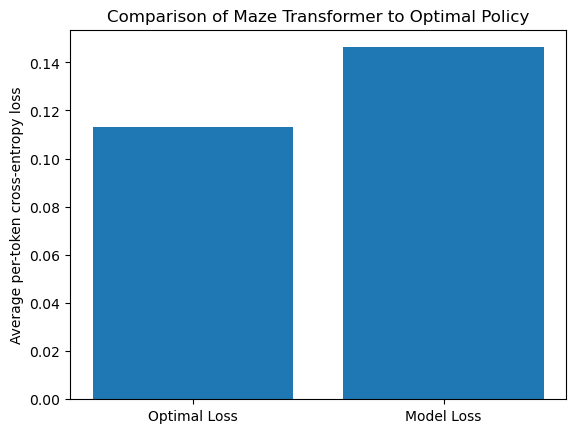

In [49]:

categories = ['Optimal Loss', 'Model Loss']
values = [np.mean(optimal_loss), np.mean(model_loss)]  # Example values for optimal loss and model loss

# Creating a bar plot
plt.bar(categories, values)

# Adding labels
plt.ylabel('Average per-token cross-entropy loss')
plt.title('Comparison of Maze Transformer to Optimal Policy')

# Display the plot

plt.savefig('optimal_vs_model.pdf')
plt.show()

# Probe setup

In [36]:
class LinearProbe(nn.Module):

  @nn.compact
  def __call__(self, x):
    # input should be batch_size x n_layers (one probe per layer) x emb_dim
    #y = nn.Dense(features=128)(x)
    #y = nn.relu(y)
    #y = nn.Dense(features=64)(x)
    #y = nn.relu(y)
    # treat the layers as 1 D spatial dimension, the model dim as channel dim
    bs = x.shape[0]
    #print(x.shape)
    #W_in = self.param('W', nn.initializers.xavier_uniform(), (num_layers+1, emb_dim, emb_dim))
    W_out = self.param('W', nn.initializers.xavier_uniform(), (num_layers+1, emb_dim, 4))
    b = self.param('b', nn.initializers.zeros, (num_layers+1, 4))
    assert x.shape == (bs, num_layers+1, emb_dim)
    x = nn.LayerNorm(reduction_axes=2, feature_axes=(1,2))(x)
    #y = einsum(W_in, x, 'l m h, bs l m -> bs l h')
    #y = nn.relu(y)
    y = einsum(W_out, x, 'l m o, bs l m -> bs l o')
    return y + b

#def concat_acts(act, first_layer, last_layer):
#  assert len(act['stream'])>=last_layer
#  stream = act['stream'][first_layer:last_layer+1]
#  #concat along model dim (i.e. keep batch and sequence positions separate)
# acts = jnp.concatenate(stream,axis=-1)
#  #print(acts.shape)
#  #acts = acts[:,:,:]
#  #print(acts.shape)
#  return acts

def prepare_acts(act):
    assert act['stream'][0].shape[0] == batch_size, act['stream'][0].shape[2] == emb_dim
    seq_len = act['stream'][0].shape[1]
    # note: input has dimensions n_layer x batch_size x sequence_len x emb_dim
    
    acts  = rearrange(act['stream'], 'layer bs seq dim -> (bs seq) layer dim')

    
    # return a tensor in which all seq positions are in one big batch, then layer, then model dim
    assert len(acts.shape)==3
    assert acts.shape == (batch_size * seq_len, num_layers+1, emb_dim)

    return acts, seq_len

In [37]:
# Linear probe training

# Start a new experiment


losses = []
eval_losses = []

#batch = next(iter(train_loader))


key = random.PRNGKey(0)

rng, key = random.split(key)


#print(f'default loss: {jnp.log()}')

pred, act = model.apply(state['params'], batch['data'])

acts, seq_len = prepare_acts(act) # this is just to initialize the probe, so take first sequence position arbitrarily

x = acts

probe = LinearProbe()

tx = optax.adamw(3e-4)

params = probe.init(rng, x)

opt_state = tx.init(params)

probe_state = {'params': params, 'opt_state': opt_state, 'loss': 0., 'step': 0}

target_dict = {
      11: 0,
      27: 1,
      29: 2,
      35: 3
  }

@functools.partial(jax.jit, static_argnums=(2,))
def probe_loss_fn(params, batch, reduce_layers = 1):
  pred, act = model.apply(state['params'], batch['data'])
      
  acts, seq_len = prepare_acts(act)
  assert seq_len == batch['data'].shape[1]

  targets = batch['data'][jnp.arange(0,pred.shape[0]),batch['end_index']-1]

  #print(targets)

  new_targets = targets.copy()

  for k, v in target_dict.items():
      new_targets = jnp.where(targets==k,v,new_targets)

  #print(new_targets)
  # expanding targets along seq len (result is shape 
  repeated_targets = jnp.repeat(new_targets, seq_len, axis = 0)
  assert repeated_targets.shape == (seq_len * batch_size,)
  repeated_targets = jnp.repeat(repeated_targets[:,None], num_layers+1, axis=1)
  assert repeated_targets.shape == (seq_len * batch_size,num_layers+1)
  

  probe_pred = probe.apply(params, acts)

  # probe preds are of shape (batch_size * seq_len, num_layer, 4)

  assert repeated_targets.shape == probe_pred.shape[:-1]

  assert len(repeated_targets.shape)==2

  loss = optax.softmax_cross_entropy_with_integer_labels(
      logits = probe_pred,
      labels = repeated_targets
  )

  # loss is of shape (batch_size * seq_len, num_layer). First, undo the reshaping.

  loss = rearrange(loss, '(bs seq) layer -> bs seq layer', bs=batch_size, seq=seq_len, layer=num_layers+1)
  
  idx = jnp.arange(seq_len)[None, :]

  mask = jnp.where((idx < batch['end_index'][:, None]) & (idx > batch['start_index'][:, None]), 1., 0.)

  # need to broadcast mask over the last layer dimension
  assert mask.shape == (batch_size,seq_len)
  loss = loss * mask[:,:,None]

  if reduce_layers:
      # just add up losses over all the layers. that's fine.
      loss = loss.sum() / mask.sum()
  else:
      loss = loss.sum(axis=(0,1))/mask.sum()

  return loss

@jax.jit
def probe_train_step(probe_state,batch):
  params = probe_state['params']
  opt_state = probe_state['opt_state']
  loss, grads = jax.value_and_grad(probe_loss_fn)(params,batch)
  updates, opt_state = tx.update(grads, opt_state, params)
  params = optax.apply_updates(params, updates)
  step = probe_state['step'] + 1

  return {'params': params, 'opt_state': opt_state, 'loss': loss, 'step': step}

@jax.jit
def probe_eval_step(state,batch):
  params = state['params']
  loss = probe_loss_fn(params,batch)
  return loss

probe_losses = []
probe_eval_losses = []


In [38]:
#@jax.jit
def optimal_loss_fn(batch):

    path_len = batch['true_probs'].shape[1]
    true_probs = batch['true_probs']
    assert true_probs.shape == (batch_size, path_len, 4)
    
    targets = batch['data'][jnp.arange(0,batch['data'].shape[0]),batch['end_index']-1]
    new_targets = targets.copy()
    
    for k, v in target_dict.items():
      new_targets = jnp.where(targets==k,v,new_targets)

    #print(new_targets)
    # expanding targets along seq len (result is shape 
    repeated_targets = jnp.repeat(new_targets, path_len, axis = 0)
    assert repeated_targets.shape == (path_len * batch_size,)

    true_probs_reshaped = rearrange(true_probs, 'bs seq i -> (bs seq) i')
    assert true_probs_reshaped.shape == (path_len * batch_size, 4)

    log_probs = jnp.log(true_probs_reshaped)

    #print(log_probs[:10])
    #print(repeated_targets[:10])

    loss = optax.softmax_cross_entropy_with_integer_labels(
          logits = log_probs,
          labels = repeated_targets
      )
    #print(loss[:10])
    
    # loss is of shape (batch_size * seq_len). First, undo the reshaping.
    
    loss = rearrange(loss, '(bs seq) -> bs seq ', bs=batch_size, seq=path_len)
    
    idx = jnp.arange(path_len)[None, :]
    
    mask = jnp.where((idx <= batch['true_probs_end_index'][:, None]), 1., 0.)
    
    assert mask.shape == (batch_size,path_len)
    loss = np.ma.array(loss, mask=1-mask)
    #print(loss[:10])

    loss = loss.mean()
    
    return loss

In [57]:
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
probe_options = orbax.checkpoint.CheckpointManagerOptions(max_to_keep=keep_n_checkpoints)
probe_checkpoint_manager = orbax.checkpoint.CheckpointManager(os.path.join(base_path,'probe_layernorm_bias'), orbax_checkpointer, probe_options)

In [84]:
# PROBE LOADING


dummy_dict = {
            'probe_state': probe_state,
            'probe_loss': np.zeros(1)}

step = probe_checkpoint_manager.latest_step()
print(f'loading step {step}')
load_dict = probe_checkpoint_manager.restore(step, items=dummy_dict)
probe_state = load_dict['probe_state']
probe_losses = list(load_dict['probe_loss'])
print(np.mean(probe_losses[-100:]))

loading step 30478
12.799657


# Probe training

In [41]:
dataset = CustomMazeDataset(include_maze=False, no_loops=False)
train_loader = NumpyLoader(dataset, batch_size=batch_size, num_workers=n_worker)

In [ ]:
loop_time = time.time()

for n, batch in enumerate(train_loader):
    # do the actual training

    probe_state = probe_train_step(probe_state, batch)
    
    probe_losses.append(probe_state['loss'])
    
    print(f'step: {probe_state["step"]}')
    print('loss: {}'.format(probe_state['loss']))
    old_time = loop_time
    loop_time = time.time()
    print('steps per second: {:.5f}'.format(1/(loop_time - old_time)))

    

    if n % 100 == 0:
        print('\n\n----- saving and eval -----')
        #optimal_loss = optimal_loss_fn(batch)
        #print(f'optimal_loss: {optimal_loss}')
        layer_losses = probe_loss_fn(probe_state['params'],batch,reduce_layers=False)
        layer, best_layer_loss = layer_losses.argmin(), layer_losses.min()
        print(f'best layer loss: {best_layer_loss}, layer: {layer}')
        probe_save_step = probe_state['step']
        print(f'saving at step {probe_save_step}')
        probe_save_dict = {'probe_state': probe_state,
                     'probe_loss': np.array(probe_losses)
                     }
        probe_save_args = orbax_utils.save_args_from_target(probe_save_dict)
        probe_checkpoint_manager.save(probe_save_step, probe_save_dict, save_kwargs={'save_args': probe_save_args})
        print('----------\n\n')
    

# note that completely oblivious loss is 1.3862944 for 4 options (since dataset is uniformly random)

step: 30479
loss: 13.317160606384277
steps per second: 0.20494


----- saving and eval -----
best layer loss: 0.8870174884796143, layer: 11
saving at step 30479
----------


step: 30480
loss: 12.4995756149292
steps per second: 0.27451
step: 30481
loss: 12.809378623962402
steps per second: 0.55220
step: 30482
loss: 12.810978889465332
steps per second: 0.56816
step: 30483
loss: 12.915701866149902
steps per second: 0.53839
step: 30484
loss: 12.969505310058594
steps per second: 0.55687
step: 30485
loss: 12.920815467834473
steps per second: 0.54213
step: 30486
loss: 12.502585411071777
steps per second: 0.56796
step: 30487
loss: 13.239951133728027
steps per second: 0.53526
step: 30488
loss: 12.682209014892578
steps per second: 0.53885
step: 30489
loss: 13.168342590332031
steps per second: 0.54195
step: 30490
loss: 13.268899917602539
steps per second: 0.54463
step: 30491
loss: 12.478841781616211
steps per second: 0.52542
step: 30492
loss: 12.3281831741333
steps per second: 0.53229
step: 30493

In [78]:
# PROBE SAVING
probe_save_step = probe_state['step']
print(f'saving at step {probe_save_step}')
probe_save_dict = {'probe_state': probe_state,
             'probe_loss': np.array(probe_losses)
             }
probe_save_args = orbax_utils.save_args_from_target(probe_save_dict)
probe_checkpoint_manager.save(probe_save_step, probe_save_dict, save_kwargs={'save_args': probe_save_args})

saving at step 30478


True

# Baseline setup

In [12]:
embeddings = jnp.array(state['params']['params']['decoder']['Embed_0']['embedding'])

def get_baseline_features(data):
    # Baseline features:
    # for simplicity, we just concatenate the embeddings of the past two tokens.
    data = jnp.array(data)
    features = embeddings[data]

    two_step_features = jnp.concatenate([features[:,:-1,:],features[:,1:,:]],axis=-1)
    seq_len = two_step_features.shape[1]
    out = rearrange(two_step_features, 'bs seq feat -> (bs seq) feat')

    return out, seq_len
    

n_baseline_probe_layers = 1
n_hidden = emb_dim

class BaselineProbe(nn.Module):
    @nn.compact
    def __call__(self, x):
        for layer in range(n_baseline_probe_layers):
            x = nn.Dense(n_hidden)(x)
            x = nn.relu(x)
        out = nn.Dense(4)(x)
        return out

In [13]:


# Start a new experiment

losses = []
eval_losses = []

#batch = next(iter(train_loader))


key = random.PRNGKey(0)

rng, key = random.split(key)

baseline_probe = BaselineProbe()

x, seq_len = get_baseline_features(batch['data'])

tx = optax.adamw(1e-4)

params = baseline_probe.init(rng, x)

opt_state = tx.init(params)

baseline_state = {'params': params, 'opt_state': opt_state, 'loss': 0., 'step': 0}

@jax.jit
def baseline_loss_fn(params, batch):
  inputs, seq_len = get_baseline_features(batch['data'])
      
  assert seq_len == batch['data'].shape[1] - 1

  targets = batch['data'][jnp.arange(0,batch_size),batch['end_index']-1]

  new_targets = targets.copy()

  for k, v in target_dict.items():
      new_targets = jnp.where(targets==k,v,new_targets)

  #print(new_targets)
  # expanding targets along seq len (result is shape 
  repeated_targets = jnp.repeat(new_targets, seq_len, axis = 0)
  assert repeated_targets.shape == (seq_len * batch_size,)

  probe_pred = baseline_probe.apply(params, inputs)

  assert repeated_targets.shape == probe_pred.shape[:-1]

  assert len(repeated_targets.shape)==1

  loss = optax.softmax_cross_entropy_with_integer_labels(
      logits = probe_pred,
      labels = repeated_targets
  )

  # loss is of shape (batch_size * seq_len, num_layer). First, undo the reshaping.

  loss = rearrange(loss, '(bs seq) -> bs seq', bs=batch_size, seq=seq_len)
  
  idx = jnp.arange(seq_len)[None, :]

  mask = jnp.where((idx < batch['end_index'][:, None]-1) & (idx > batch['start_index'][:, None]-1), 1., 0.)

  # need to broadcast mask over the last layer dimension
  assert mask.shape == (batch_size,seq_len)
  loss = loss * mask
  loss = loss.sum()/mask.sum()

  return loss

@jax.jit
def baseline_train_step(baseline_state,batch):
  params = baseline_state['params']
  opt_state = baseline_state['opt_state']
  loss, grads = jax.value_and_grad(baseline_loss_fn)(params,batch)
  updates, opt_state = tx.update(grads, opt_state, params)
  params = optax.apply_updates(params, updates)
  step = baseline_state['step'] + 1

  return {'params': params, 'opt_state': opt_state, 'loss': loss, 'step': step}

baseline_losses = []


In [14]:
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
baseline_options = orbax.checkpoint.CheckpointManagerOptions(max_to_keep=1000)
baseline_checkpoint_manager = orbax.checkpoint.CheckpointManager(os.path.join(base_path,'baseline_probe_1hidden_loops'), orbax_checkpointer, baseline_options)

In [15]:
# BASELINE PROBE LOADING
dummy_dict = {
            'baseline_state': baseline_state,
            'baseline_loss': np.zeros(1)}

step = baseline_checkpoint_manager.latest_step()
print(f'loading step {step}')
load_dict = baseline_checkpoint_manager.restore(step, items=dummy_dict)
baseline_state = load_dict['baseline_state']
baseline_losses = list(load_dict['baseline_loss'])
print(np.mean(baseline_losses[-100:]))

loading step 91002
1.0657879


# Probe analysis

30478
12.799657


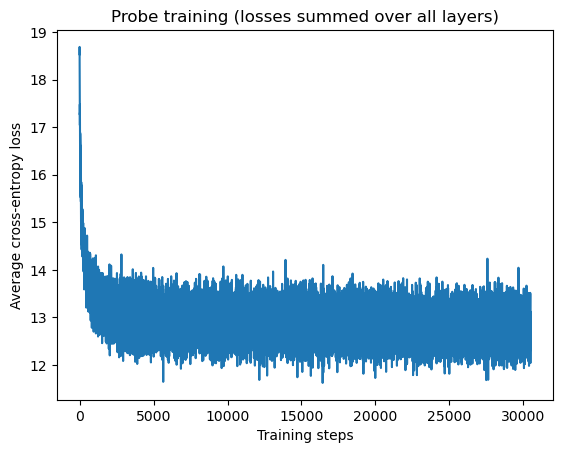

In [83]:
print(len(probe_losses))
print(np.mean(probe_losses[-100:]))

#plt.plot(old_probe_losses)
plt.plot(probe_losses)
#plt.xscale('log')
#plt.yscale('log')
plt.title('Probe training (losses summed over all layers)')
plt.xlabel('Training steps')
plt.ylabel('Average cross-entropy loss')
plt.savefig('probe_training.pdf')

In [80]:
#@jax.jit
def optimal_loss_fn(batch):

    path_len = batch['true_probs'].shape[1]
    true_probs = batch['true_probs']
    assert true_probs.shape == (batch_size, path_len, 4)
    
    targets = batch['data'][jnp.arange(0,batch['data'].shape[0]),batch['end_index']-1]
    new_targets = targets.copy()
    
    for k, v in target_dict.items():
      new_targets = jnp.where(targets==k,v,new_targets)

    #print(new_targets)
    # expanding targets along seq len (result is shape 
    repeated_targets = jnp.repeat(new_targets, path_len, axis = 0)
    assert repeated_targets.shape == (path_len * batch_size,)

    true_probs_reshaped = rearrange(true_probs, 'bs seq i -> (bs seq) i')
    assert true_probs_reshaped.shape == (path_len * batch_size, 4)

    log_probs = jnp.log(true_probs_reshaped)

    #print(log_probs[:10])
    #print(repeated_targets[:10])

    loss = optax.softmax_cross_entropy_with_integer_labels(
          logits = log_probs,
          labels = repeated_targets
      )
    #print(loss[:10])
    
    # loss is of shape (batch_size * seq_len). First, undo the reshaping.
    
    loss = rearrange(loss, '(bs seq) -> bs seq ', bs=batch_size, seq=path_len)
    
    idx = jnp.arange(path_len)[None, :]
    
    mask = jnp.where((idx <= batch['true_probs_end_index'][:, None]), 1., 0.)
    
    assert mask.shape == (batch_size,path_len)
    loss = np.ma.array(loss, mask=1-mask)
    #print(loss[:10])

    loss = loss.mean()
    
    return loss

In [81]:
# Now get an estimate of optimal loss, and probe losses for all layers, and baseline 

dataset = CustomMazeDataset(include_maze=False,no_loops=True)
train_loader_iter = iter(NumpyLoader(dataset, batch_size=batch_size, num_workers=n_worker))

probe_loss = {i: [] for i in range(13)}
optimal_loss = []
baseline_loss = []

for n in range(10):
    batch = next(train_loader_iter)
    loss = optimal_loss_fn(batch)
    optimal_loss.append(loss)
    loss = probe_loss_fn(probe_state['params'],batch, reduce_layers=False)
    for i in range(13):
        probe_loss[i].append(loss[i])
    loss = baseline_loss_fn(baseline_state['params'], batch)
    baseline_loss.append(loss)


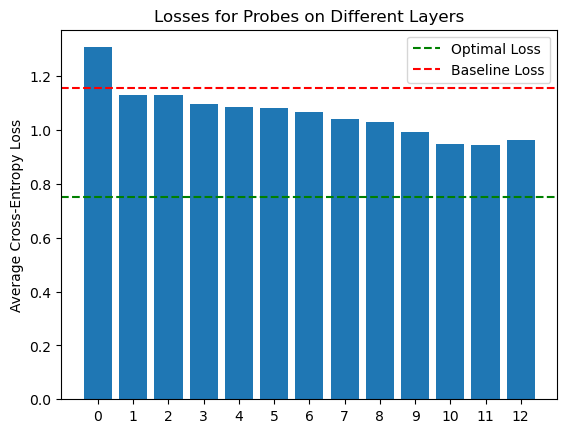

In [82]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate mean values for the horizontal lines
optimal_loss_value = np.mean(optimal_loss)
baseline_loss_value = np.mean(baseline_loss)

# Sample data for the bar plot
categories = [f'{i}' for i in range(13)]
values = [np.mean(probe_loss[i]) for i in range(13)] 

# Adding the horizontal lines with labels
plt.axhline(optimal_loss_value, color='green', linestyle='--', label='Optimal Loss')
plt.axhline(baseline_loss_value, color='red', linestyle='--', label='Baseline Loss')

# Creating a bar plot
plt.bar(categories, values)

# Adding labels and title
plt.ylabel('Average Cross-Entropy Loss')
plt.title('Losses for Probes on Different Layers')

# Add a legend to the plot
plt.legend()

# Display the plot and save the figure

plt.savefig('probes_different_layers_baseline.pdf')
plt.show()

# Other analysis

In [28]:
def get_probe_probs(probe_params, act):
      
  acts, seq_len = prepare_acts(act)

  probe_preds = probe.apply(probe_params, acts)

  probe_probs = nn.softmax(probe_preds, axis=-1)

  #undo the batching again. Have a new dimension with the 4 probe probabilities now

  return rearrange(probe_probs, '(bs seq) layer pred -> bs seq layer pred', bs=batch_size, seq=seq_len)

reverse_target_dict = {v:k for k,v in target_dict.items()}

In [29]:
dataset = CustomMazeDataset(include_maze=True)
train_loader = NumpyLoader(dataset, batch_size=batch_size, num_workers=0)

batch = next(iter(train_loader))

print(reverse_target_dict)

{0: 11, 1: 27, 2: 29, 3: 35}


In [67]:
# first, print the mazes again

preds, act = model.apply(state['params'],batch['data'])

for i in range(20):
  print(f'\nex {i}')

  print(batch['data'][i,batch['start_index'][i]:batch['end_index'][i]+1])
  print(jnp.argmax(preds[i,batch['start_index'][i]:batch['end_index'][i]-1],axis=-1))
  plot = MazePlot(batch['maze'][i])
  path = ints_to_coords(jnp.argmax(preds[i,batch['start_index'][i]:batch['end_index'][i]-1],axis=-1))
  #plot.add_predicted_path(path)
  plot.plot()


ex 0
[ 6 14 12 11 13 16 21 29  7]
[14 12 11 13 16 21 29]


KeyError: 'maze'

In [37]:
maze_num = 3
timestep = 3


import copy

x_mod = copy.deepcopy(batch)

#x_mod['data'][maze_num][x_mod['start_index'][maze_num]+2] = vocab_map('(1,1)')
#x_mod['data'][maze_num][x_mod['start_index'][maze_num]+7] = vocab_map('(3,4)')
#x_mod['data'][maze_num][x_mod['start_index'][maze_num]+8] = vocab_map('(4,4)')
#x_mod['data'][maze_num][x_mod['start_index'][maze_num]+9] = vocab_map('(4,3)')
#x_mod['end_index'][maze_num]=x['end_index'][maze_num]+1
#intervention = get_intervention(probe_state,alpha=200, min_layer=5, goal_i=target_dict[vocab_map('(4,4)')])
#intervention = get_intervention(probe_state,x_mod, alpha=100, min_layer=3, goal_i=target_dict[vocab_map('(0,0)')],timestep=timestep)
#intervention = lambda y,i:y

preds, act = model.apply(state['params'],x_mod['data'])#, intervention=intervention)
print(preds[maze_num][timestep])


probe_probs = get_probe_probs(probe_state['params'],act)


for t in range(x_mod['start_index'][maze_num],x_mod['end_index'][maze_num]):
  print('\ntime step {}'.format(t-x_mod['start_index'][maze_num]))
  print('current input {}'.format(reverse_map[x_mod['data'][maze_num][t]]))
  print('maze transformer prediction')
  print(sorted([(reverse_map[i],nn.softmax(preds[maze_num][t])[i]) for i in range(len(reverse_map))],key=lambda x: -x[1])[:4])
  
  for layer in [10]:
      print(f'probe probs layer {layer}:')
      step_probs = sorted([(reverse_map[pos],probe_probs[maze_num][t][layer][i]) for pos, i in target_dict.items()],key=lambda x: -x[1])[:4]
      print(step_probs)
  print('target:')
  print(reverse_map[x_mod['data'][maze_num][x_mod['end_index'][maze_num]-1]])

[ -0.126997   -11.275179   -11.832291   -11.381224   -11.654282
 -11.633515   -11.169894    -2.4338238  -11.505222   -11.5296135
 -11.401617    -2.2874143   -0.95169276   0.43281287  -0.02550286
  -3.0204818   -2.3760512   -1.2796539   -1.1155916   -0.43775648
  -0.3464061   -0.73989344  -1.9397299   -0.5459655   -0.2479166
  -1.4032001    4.1710773   -2.5551846    3.9759185   -2.0420656
   2.077173     0.20904179   1.1315657    2.729878    -0.3045999
   5.756655  ]

time step 0
current input <PATH_START>
maze transformer prediction
[('(0,0)', Array(0.99996865, dtype=float32)), ('(0,2)', Array(2.592906e-05, dtype=float32)), ('(2,1)', Array(8.403131e-07, dtype=float32)), ('(2,2)', Array(8.1038553e-07, dtype=float32))]
probe probs layer 10:
[('(0,0)', Array(0.39317104, dtype=float32)), ('(4,0)', Array(0.3553958, dtype=float32)), ('(4,4)', Array(0.19600609, dtype=float32)), ('(0,4)', Array(0.05542712, dtype=float32))]
target:
(0,4)

time step 1
current input (0,0)
maze transformer predict

# Logit lens

In [ ]:
# Have to extract the unembedding from the model state
# Then apply it to all the captured activations, for each layer
# Print the output distribution for each layer, as well as the loss...

class LogitLens(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.LayerNorm(name='encoderdecoder_norm')(x)
        x = nn.Dense(vocab_size, name='logitdense')(x)
        return x

In [ ]:
logitlens = LogitLens()

CallCompactUnboundModuleError: Can't call compact methods on unbound modules (https://flax.readthedocs.io/en/latest/api_reference/flax.errors.html#flax.errors.CallCompactUnboundModuleError)

In [26]:
def logit_lens(state, batch):
    preds, act = model.apply(state['params'],batch['data'])
    acts = rearrange(act,'layer b seq dmodel -> b seq layer dmodel')
    nn.LayerNorm()
    
    b = state['params']['params']['decoder']['logitdense']['bias']
    W = state['params']['params']['decoder']['logitdense']['kernel']
    logits = b[None,None,None,:] + einsum(W, act['stream'], 'dmodel o, layer b seq dmodel -> b seq layer o')
    return logits

In [38]:
maze_num = 3
timestep = 3


import copy

x_mod = copy.deepcopy(batch)

#x_mod['data'][maze_num][x_mod['start_index'][maze_num]+2] = vocab_map('(1,1)')
#x_mod['data'][maze_num][x_mod['start_index'][maze_num]+7] = vocab_map('(3,4)')
#x_mod['data'][maze_num][x_mod['start_index'][maze_num]+8] = vocab_map('(4,4)')
#x_mod['data'][maze_num][x_mod['start_index'][maze_num]+9] = vocab_map('(4,3)')
#x_mod['end_index'][maze_num]=x['end_index'][maze_num]+1
#intervention = get_intervention(probe_state,alpha=200, min_layer=5, goal_i=target_dict[vocab_map('(4,4)')])
#intervention = get_intervention(probe_state,x_mod, alpha=100, min_layer=3, goal_i=target_dict[vocab_map('(0,0)')],timestep=timestep)
#intervention = lambda y,i:y

logits = logit_lens(state,batch)
print(logits[maze_num][timestep])

#probe_probs = get_probe_probs(probe_state['params'],act)


for t in range(x_mod['start_index'][maze_num],x_mod['end_index'][maze_num]):
    print('\ntime step {}'.format(t-x_mod['start_index'][maze_num]))
    print('current input {}'.format(reverse_map[x_mod['data'][maze_num][t]]))
    print('maze transformer prediction')

  
    for layer in range(13):
        print(f'logit lense layer {layer}:')
        print(sorted([(reverse_map[i],nn.softmax(logits[maze_num][t][layer])[i]) for i in range(len(reverse_map))],key=lambda x: -x[1])[:4])
    print('target:')
    print(reverse_map[x_mod['data'][maze_num][x_mod['end_index'][maze_num]-1]])

[[-5.65857315e+00 -6.74975348e+00 -7.65854454e+00 -6.89025116e+00
  -8.08977890e+00 -7.01545763e+00 -8.52140427e+00  2.95713973e+00
  -6.98287249e+00 -7.31125641e+00 -6.78649950e+00 -3.30939561e-01
  -7.30514765e-01 -2.83564782e+00  2.62907457e+00  3.08047986e+00
   6.52385280e-02 -3.18877029e+00 -7.70843685e-01 -4.18714857e+00
   2.80602837e+00  7.63528824e-01  3.14187765e-01 -3.07798266e+00
   1.03060150e+00 -1.78376377e-01  3.35681129e+00  1.27394724e+00
   3.91255164e+00  1.01682276e-01  2.56090426e+00 -7.80808568e-01
  -9.36475635e-01 -8.85703862e-01 -1.44930542e+00  4.71074390e+00]
 [ 3.22508659e+01 -1.09103088e+01 -1.45863819e+01 -7.16484308e+00
  -1.31753864e+01 -6.51650047e+00 -8.71810436e+00  1.31070232e+00
  -8.71619987e+00 -7.52824497e+00 -7.20918512e+00 -2.87929273e+00
  -6.59068680e+00 -5.36014509e+00 -1.43197298e+00  2.47716475e+00
  -1.64355755e+00 -6.61014700e+00 -8.20018482e+00  5.40718973e-01
   1.44265807e+00  1.00457668e+00 -3.29704523e-01 -3.50654507e+00
   5.8147